In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as tfl
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator



In [ ]:
df = pd.read_csv('MovieGenre.csv', encoding = 'latin-1')
df = df.head(1000)

In [ ]:
import urllib.request
from PIL import Image
from io import BytesIO

In [ ]:
df.drop(columns=[ 'Imdb Link','IMDB Score',], inplace=True)
df.dropna(inplace=True)
df.head(5)


,imdbId,Title,Genre,Poster
0,114709,Toy Story (1995),Animation|Adventure|Comedy,https://images-na.ssl-images-amazon.com/images...
1,113497,Jumanji (1995),Action|Adventure|Family,https://images-na.ssl-images-amazon.com/images...
2,113228,Grumpier Old Men (1995),Comedy|Romance,https://images-na.ssl-images-amazon.com/images...
3,114885,Waiting to Exhale (1995),Comedy|Drama|Romance,https://images-na.ssl-images-amazon.com/images...
4,113041,Father of the Bride Part II (1995),Comedy|Family|Romance,https://images-na.ssl-images-amazon.com/images...


In [ ]:
df['Genre'] = df['Genre'].str.split('|')

# Get all unique genres
unique_genres = set()
for genres in df['Genre']:
    unique_genres.update(genres)

for genre in unique_genres:
    df[genre] = df['Genre'].apply(lambda x: 1 if genre in x else 0)

# Drop the original 'Genres' column if needed
df.drop('Genre', axis=1, inplace=True)

df.head(5)

,imdbId,Title,Poster,Action,Musical,Thriller,Sci-Fi,Fantasy,Biography,War,...,Film-Noir,Mystery,History,Animation,Drama,Music,Adventure,Documentary,Crime,Sport
0,114709,Toy Story (1995),https://images-na.ssl-images-amazon.com/images...,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
1,113497,Jumanji (1995),https://images-na.ssl-images-amazon.com/images...,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,113228,Grumpier Old Men (1995),https://images-na.ssl-images-amazon.com/images...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,114885,Waiting to Exhale (1995),https://images-na.ssl-images-amazon.com/images...,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,113041,Father of the Bride Part II (1995),https://images-na.ssl-images-amazon.com/images...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df.isnull().sum()

imdbId         0
Title          0
Poster         0
Action         0
Musical        0
Thriller       0
Sci-Fi         0
Fantasy        0
Biography      0
War            0
Short          0
Romance        0
Comedy         0
Western        0
Family         0
Horror         0
Film-Noir      0
Mystery        0
History        0
Animation      0
Drama          0
Music          0
Adventure      0
Documentary    0
Crime          0
Sport          0
dtype: int64

In [ ]:
for x in df.columns:
    if x != 'imdbId':
        df.drop(columns={x},inplace=True)
    if x=='imdbId':
        break



In [ ]:
df.columns

Index(['imdbId', 'Title', 'Poster', 'Action', 'Musical', 'Thriller', 'Sci-Fi',
       'Fantasy', 'Biography', 'War', 'Short', 'Romance', 'Comedy', 'Western',
       'Family', 'Horror', 'Film-Noir', 'Mystery', 'History', 'Animation',
       'Drama', 'Music', 'Adventure', 'Documentary', 'Crime', 'Sport'],
      dtype='object')

In [ ]:
df['Action'].value_counts()

Action
0    845
1    142
Name: count, dtype: int64

In [ ]:
data=df.iloc[:,3:]

In [ ]:
average_count = data.sum(axis=0).mean()
print(average_count)

102.52173913043478


In [ ]:
# uncomment if you don't want to remove the columns below mean

value_counts = df.iloc[:,3:].apply(pd.value_counts)

# Define a threshold for the value counts
threshold = average_count  # Adjust this threshold based on your criteria

# Identify columns where the value counts are below the threshold
columns_to_drop = value_counts.columns[value_counts.min() < threshold]

# Drop the identified columns from the DataFrame
df = df.drop(columns=columns_to_drop)

<Figure size 1000x600 with 0 Axes>

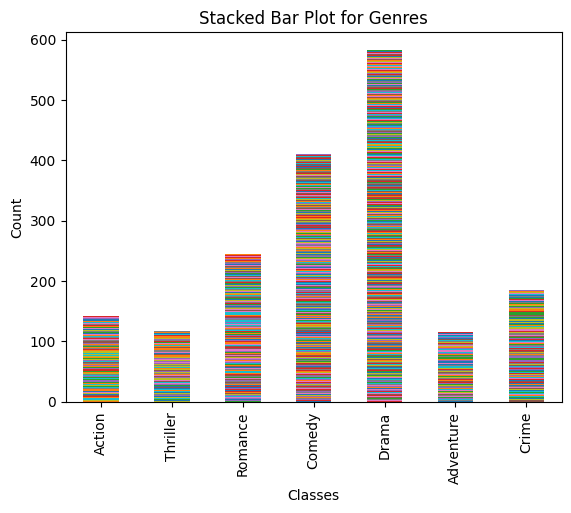

In [ ]:
# Heatmap
import matplotlib.pyplot as plt
data=df.iloc[:,3:]

# Stacked Bar Plot
plt.figure(figsize=(10, 6))
data.T.plot(kind='bar', stacked=True)
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Stacked Bar Plot for Genres')
plt.xticks(rotation=90)
plt.legend().remove()
#plt.legend(title='Index', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

#Preprocessing image and converting them to RGB values and normalizing them

In [ ]:
import tensorflow as tf
from PIL import Image
import numpy as np
import os
from sklearn.model_selection import train_test_split

# Function to preprocess image
def preprocess_image(image_path):
    # Open image
    try:
      with urllib.request.urlopen(image_path) as response:
          data = response.read()
          img = Image.open(BytesIO(data))
    except:
        img = Image.open(image_path)

    # Resize to 224x224 pixels
    img = img.resize((224, 224))
    img = img.convert('RGB')
        # Convert to grayscale
    #img = img.convert('L')
        # Convert image to numpy array
    img_array = np.array(img)
        # Normalize pixel values to [0, 1]
    img_array = img_array / 255.0
        # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)
    return img_array



In [ ]:
X = []  # List of preprocessed images
  # List of corresponding genres
for index, row in df.iterrows():
    image_path = row['Poster']  # Assuming 'image_path' contains the file paths of images
    #genre = row[3:]  # Assuming 'genre' contains the genre labels
    try:
      preprocessed_image = preprocess_image(image_path)
      X.append(preprocessed_image)
    except:
       df.drop(df[df['Poster'] == image_path].index, inplace=True)
       pass

In [ ]:
y = df.iloc[:,3:].to_numpy()
    #y.append(genre)
print("array denotion")
# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)
print("splitting")
# 2. Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

array denotion
splitting


In [ ]:
print(X_train.shape, y_train.shape)

(639, 1, 224, 224, 3) (639, 7)


#Training The Model


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Create a Sequential model
logistic_regression_model = Sequential()

# Add a dense layer with 5 units and softmax activation for classification
logistic_regression_model.add(Dense(5, activation='softmax', input_shape=(224, 224, 3)))

# Print model summary
logistic_regression_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 224, 224, 5)       20        
                                                                 
Total params: 20 (80.00 Byte)
Trainable params: 20 (80.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
logistic_regression_model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
def show(image):
    import matplotlib.pyplot as plt

    # Plot the image using Matplotlib
    plt.imshow(image)
    plt.axis('off')  # Turn off axis
    plt.show()

In [ ]:
from PIL import Image
import requests
import numpy as np

def preprocess_image(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))

    # Convert image to RGB mode to ensure it has 3 channels
    img = img.convert('RGB')

    img = img.resize((224, 224))
    img = np.array(img)
    img = img / 255.0  # Normalization
    return img




Processing file: https://media.timeout.com/images/106027003/1024/576/image.webp


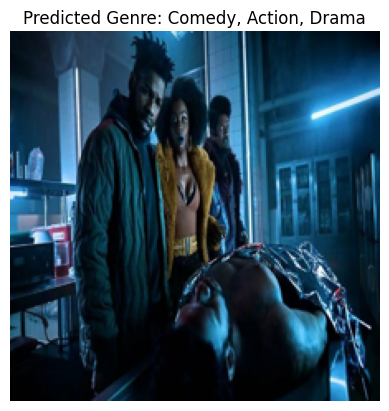

Top 3 predicted genres for https://media.timeout.com/images/106027003/1024/576/image.webp :
Genre: Comedy Probability: 0.9995045239135285
Genre: Action Probability: 0.00034251687574941646
Genre: Drama Probability: 0.0001093578135407419
Processing file: https://movies.universalpictures.com/media/opr-tsr1sheet3-look2-rgb-3-1-1-64545c0d15f1e-1.jpg


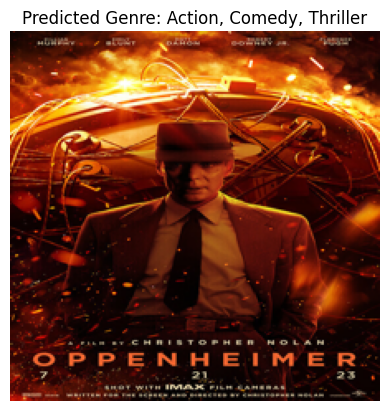

Top 3 predicted genres for https://movies.universalpictures.com/media/opr-tsr1sheet3-look2-rgb-3-1-1-64545c0d15f1e-1.jpg :
Genre: Action Probability: 0.9995789052531918
Genre: Comedy Probability: 0.00031502316844985633
Genre: Thriller Probability: 8.359681774250674e-05
Processing file: https://www.kenosha.com/wp-content/uploads/2023/08/et00072466-jjadjvahwx-landscape-copy.png


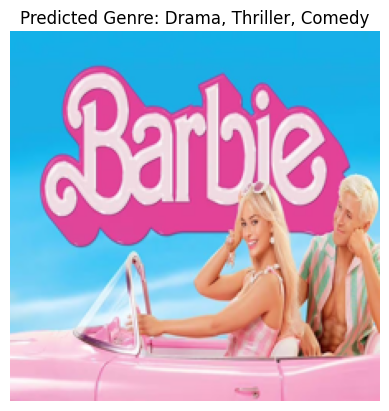

Top 3 predicted genres for https://www.kenosha.com/wp-content/uploads/2023/08/et00072466-jjadjvahwx-landscape-copy.png :
Genre: Drama Probability: 0.9996586521765388
Genre: Thriller Probability: 0.0002069701424275071
Genre: Comedy Probability: 0.00011674269526129536
Processing file: https://theobjectivestandard.com/wp-content/uploads/2022/03/3-Idiots-Written-and-Directed-by-Rajkumar-Hirani-2048x1216.jpg


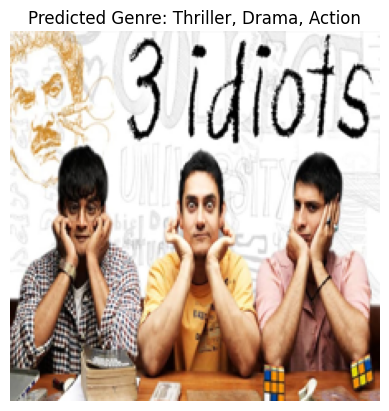

Top 3 predicted genres for https://theobjectivestandard.com/wp-content/uploads/2022/03/3-Idiots-Written-and-Directed-by-Rajkumar-Hirani-2048x1216.jpg :
Genre: Thriller Probability: 0.9996312576469164
Genre: Drama Probability: 0.00024092782943685567
Genre: Action Probability: 8.91459392663816e-05


In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

# Function to preprocess image
def preprocess_image(image_path):
    try:
        response = requests.get(image_path)
        img = Image.open(BytesIO(response.content))
    except:
        img = Image.open(image_path)

    # Resize to 224x224 pixels
    img = img.resize((224, 224))
    img = img.convert('RGB')
    img_array = np.array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img, img_array

# List of file paths
file_paths = [
    r'https://media.timeout.com/images/106027003/1024/576/image.webp',
    r'https://movies.universalpictures.com/media/opr-tsr1sheet3-look2-rgb-3-1-1-64545c0d15f1e-1.jpg',
    r'https://www.kenosha.com/wp-content/uploads/2023/08/et00072466-jjadjvahwx-landscape-copy.png',
    r'https://theobjectivestandard.com/wp-content/uploads/2022/03/3-Idiots-Written-and-Directed-by-Rajkumar-Hirani-2048x1216.jpg'
]

# Corresponding genre labels (assuming you know the labels)
genre_labels = ['Comedy', 'Action', 'Drama', 'Thriller']

# Initialize logistic regression model
logistic_model = LogisticRegression(max_iter=1000)

# Initialize lists to store features and labels
X_train_features = []
y_train_labels = []

# Extract features from images
for file_path in file_paths:
    # Preprocess the image
    img, preprocessed_image = preprocess_image(file_path)

    # Extract features (for simplicity, we'll use flattened image pixels)
    features = preprocessed_image.reshape(-1)

    # Add features to the feature list
    X_train_features.append(features)

    # Get genre label index based on file path index
    label_index = file_paths.index(file_path)

    # Add label to the label list
    y_train_labels.append(label_index)

# Convert lists to numpy arrays
X_train_features = np.array(X_train_features)
y_train_labels = np.array(y_train_labels)

# Train the logistic regression model
logistic_model.fit(X_train_features, y_train_labels)

# Make predictions for each image
for i, file_path in enumerate(file_paths):
    print("Processing file:", file_path)

    # Preprocess the image
    preprocessed_image = preprocess_image(file_path)[1]

    # Extract features (for simplicity, we'll use flattened image pixels)
    features = preprocessed_image.reshape(-1)

    # Make prediction using the trained logistic regression model
    predicted_proba = logistic_model.predict_proba([features])[0]

    # Get the top 3 predicted genre labels and probabilities
    top_3_indices = predicted_proba.argsort()[-3:][::-1]
    top_3_genres = [genre_labels[idx] for idx in top_3_indices]
    top_3_probabilities = predicted_proba[top_3_indices]

    # Display the image
    img, _ = preprocess_image(file_path)
    plt.imshow(img)
    plt.title("Predicted Genre: " + ", ".join(top_3_genres))
    plt.axis('off')
    plt.show()

    # Print the top 3 predicted genres and probabilities for the image
    print("Top 3 predicted genres for", file_path, ":")
    for genre, probability in zip(top_3_genres, top_3_probabilities):
        print("Genre:", genre, "Probability:", probability)


In [ ]:
# Train the logistic regression model
logistic_model.fit(X_train_features, y_train_labels)

# Evaluate the logistic regression model
accuracy = logistic_model.score(X_train_features, y_train_labels)
print("Accuracy:", accuracy)


Accuracy: 1.0


In [ ]:
from sklearn.metrics import classification_report

# Make predictions for training data
y_train_pred = logistic_model.predict(X_train_features)

# Generate classification report
report = classification_report(y_train_labels, y_train_pred)

# Print classification report
print(report)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



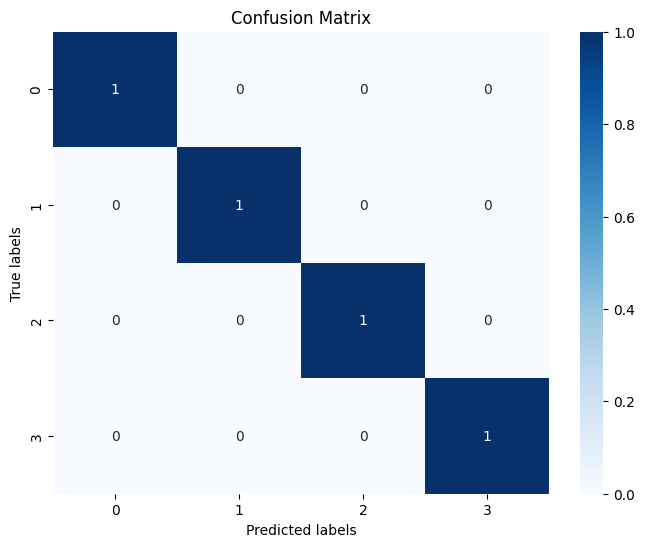

In [ ]:
# Train the logistic regression model
logistic_model.fit(X_train_features, y_train_labels)

# Make predictions for each image
y_pred = logistic_model.predict(X_train_features)

# Calculate confusion matrix
conf_mat = confusion_matrix(y_train_labels, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()
